# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [9]:
#import matplotlib.pyplot as plt
import networkx as nx
import utils
import numpy as np

In [10]:
imageArray = utils.loadImage(path="./img",name="modifiedThinn.png")
colorImage = utils.loadImage(path="./img",name="modifiedThinn.png", color=True)

[149, 210]


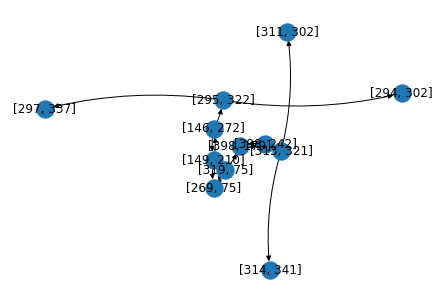

In [11]:
G = nx.MultiDiGraph()

class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass


def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[0]][adjacentPixel[1]] == 255:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for x in range(0,len(image)):
        for y in range(0,len(image[x])):
            if image[x][y] == 255:
                return (x,y)

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    #visitedPixel = []
    def recursiveFindValidPoint(currentPixel,lastPixel):
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])    
        return recursiveFindValidPoint(adjacentPixels[0],currentPixel)
    return recursiveFindValidPoint(startPoint,None)

def generateGraph(image,startPoint):
    visitedPixels = []
    graph = nx.MultiDiGraph()
    graph.add_node(str(startPoint))

    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode):
        
        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if str(currentPixel) in graph:
                graph.add_edge(lastGraphNode,str(currentPixel))
            return
        
        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            colorImage[0][currentPixel[0]][currentPixel[1]] = 0
            graph.add_node(str(currentPixel),nodeType=EndNode())
            graph.add_edge(lastGraphNode,str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            colorImage[1][currentPixel[0]][currentPixel[1]] = 0
            recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode)
        else:
            #INTERSECTION
            colorImage[2][currentPixel[0]][currentPixel[1]] = 0
            if(str(currentPixel) != lastGraphNode):
                graph.add_node(str(currentPixel),nodeType=IntersectionNode())
                graph.add_edge(lastGraphNode,str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel))

    recursiveGenerateGraph(startPoint,None,str(startPoint))
    return graph

startingPoint = findStaringPoint(imageArray)
startingPoint = findValidPoint(imageArray,startingPoint)

print(startingPoint)

G = generateGraph(imageArray,startingPoint)


utils.saveImage(name="color.png", image=colorImage, color=True)
nx.draw(G, with_labels=True,connectionstyle='arc3, rad = 0.1')